In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Labels

In [3]:
labels_df = pd.read_csv('data/secom_labels.data', sep=' ', header = None)
labels_df.columns = ['Label', 'Date']
labels_df['Date'] = pd.to_datetime(labels_df['Date'], format = "%d/%m/%Y %H:%M:%S")
print('labels_df shape = {}'.format(labels_df.shape))
labels_df.head()

labels_df shape = (1567, 2)


,Label,Date
0,-1,2008-07-19 11:55:00
1,-1,2008-07-19 12:32:00
2,1,2008-07-19 13:17:00
3,-1,2008-07-19 14:43:00
4,-1,2008-07-19 15:22:00


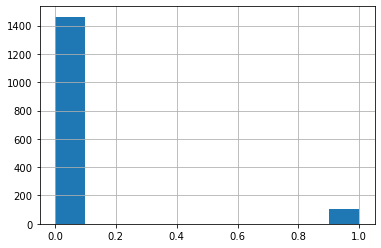

In [4]:
labels_df['Label'] = labels_df['Label'].apply(lambda x: 0 if x == -1 else 1)
labels_df['Label'].hist()

In [5]:
label_sum = labels_df['Label'].groupby(labels_df['Date'].dt.date).sum().reset_index()
label_count = labels_df['Label'].groupby(labels_df['Date'].dt.date).count().reset_index()
label_day = pd.merge(label_sum, label_count, on='Date')
label_day.columns = ['Date', 'Sum', 'Count']
label_day['Date'] = pd.to_datetime(label_day['Date'])
label_day.head()

,Date,Sum,Count
0,2008-07-19,3,12
1,2008-07-20,0,1
2,2008-07-21,1,2
3,2008-07-22,0,6
4,2008-07-23,0,2


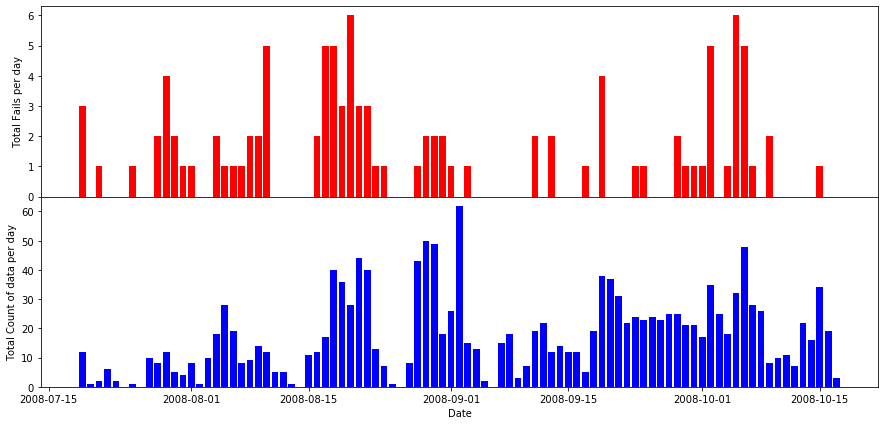

In [6]:
# Create a figure with shared X axis
fig, axs = plt.subplots(2, 1, sharex=True, figsize = (15,7))

# Remove horizontal space between axes
fig.subplots_adjust(hspace=0)

# Set the width of the bars to be 1 day
#width = np.timedelta64(1, 'D')

# Plot the Sum of fails per day and count of entries per day
axs[0].bar(label_day['Date'], label_day['Sum'], color = 'red')
axs[1].bar(label_day['Date'], label_day['Count'], color = 'blue')
axs[0].set_ylabel('Total Fails per day')
axs[1].set_ylabel('Total Count of data per day')
axs[1].set_xlabel('Date');

In [7]:
# Data

In [8]:
data_df = pd.read_csv('data/secom.data', sep=' ', header = None)
print('data_df shape = {}'.format(data_df.shape))
data_df.columns = ['x_{}'.format(i) for i in range (0,590)]
data_df.head()

data_df shape = (1567, 590)


,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,x_580,x_581,x_582,x_583,x_584,x_585,x_586,x_587,x_588,x_589
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432


In [9]:
# Merging Data and Labels

In [10]:
merged_df = data_df.merge(labels_df, left_index=True, right_index=True)
print(merged_df.shape)
merged_df.head()

(1567, 592)


,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,x_582,x_583,x_584,x_585,x_586,x_587,x_588,x_589,Label,Date
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,0,2008-07-19 11:55:00
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,0,2008-07-19 12:32:00
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1,2008-07-19 13:17:00
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,0,2008-07-19 14:43:00
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,0,2008-07-19 15:22:00


Strategy
1. Test for univariate correlation and remove those columns with no correlation to label (chi square)
3. Feature scaling
4. Downsample 100 times and build a model each time.
5. Final prediction is ensemble of all models

#### Method1: Split Train and Test randomly

In [86]:
# Split Train and Test randomly
from sklearn.model_selection import train_test_split
X = merged_df.iloc[:,:-2]
y = merged_df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [87]:
# Imputation
from sklearn.impute import SimpleImputer

imp = SimpleImputer(strategy='median').fit(X_train)

X_train_imp = pd.DataFrame(imp.transform(X_train))
X_train_imp.columns = X_train.columns
X_train_imp.index = X_train.index

X_test_imp = pd.DataFrame(imp.transform(X_test))
X_test_imp.columns = X_test.columns
X_test_imp.index = X_test.index


# Scaling
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler().fit(X_train_imp)

X_train_imp_scaled = pd.DataFrame(scaler.transform(X_train_imp))
X_train_imp_scaled.columns = X_train_imp.columns
X_train_imp_scaled.index = X_train_imp.index

X_test_imp_scaled = pd.DataFrame(scaler.transform(X_test_imp))
X_test_imp_scaled.columns = X_test_imp.columns
X_test_imp_scaled.index = X_test_imp.index

In [97]:
# Chi square
from sklearn.feature_selection import SelectKBest, chi2

def feature_prescreen(df_data, X, y):      
    data_X = df_data[X]
    data_X = data_X.fillna(data_X.median()).fillna(0).as_matrix().astype(float)
    
    scaler = MinMaxScaler()
    data_X = scaler.fit_transform(data_X)    
    data_Y = df_data[y].apply(lambda x: 0 if x==0 else 1).as_matrix() 
    
    # Get top features
    feature_selector = SelectKBest(chi2, k='all') 
    feature_selector.fit(data_X, data_Y)
    feature_idx = np.arange(data_X.shape[1])[feature_selector.get_support()].tolist()
    features = np.array(X)[feature_idx].tolist()
    scores = feature_selector.scores_[feature_idx].tolist()    
    pvalues = feature_selector.pvalues_[feature_idx].tolist()    
    
    feature_prescreen_ranking = pd.DataFrame({'feature': features, 'score': scores, 'pvalue': pvalues})    
    feature_prescreen_ranking = feature_prescreen_ranking.sort_values(['score'], ascending=False).reset_index()   
    
    return feature_prescreen_ranking

df_modelling_data = X_train_imp_scaled.merge(y_train, left_index=True, right_index=True)
X = df_modelling_data.columns[:-1]
y = 'Label'

PRESCREEN_CHI_SQUARED_PVALUE = 0.5 #Tuning Parameter

feature_prescreen_ranking = feature_prescreen(df_modelling_data, X, y) 
prescreen_features = feature_prescreen_ranking[feature_prescreen_ranking['pvalue'] < PRESCREEN_CHI_SQUARED_PVALUE]['feature'].tolist()

# Split features (X) and response (y)
X_train = X_train_imp_scaled[prescreen_features].reset_index(drop=True)
X_test = X_test_imp_scaled[prescreen_features].reset_index(drop=True)

In [98]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA

In [99]:
smt = SMOTE()
X_train_sam, y_train_sam = smt.fit_sample(X_train, y_train)

clf = GradientBoostingClassifier().fit(X_train_sam, y_train_sam)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

from sklearn import metrics
name = 'Classifier'
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred_train)
precision = metrics.precision_score(y_train, y_pred_train)
recall = metrics.recall_score(y_train, y_pred_train)
fmeasure = metrics.f1_score(y_train, y_pred_train)
print('{} train AUC: {:0.2f}'.format(name, metrics.auc(fpr, tpr)))
print('Train Precision: {:0.2f}. Train Recall: {:0.2f}. Train FMeasure: {:0.2f}\n'.format(precision, recall, fmeasure))

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_test)
precision = metrics.precision_score(y_test, y_pred_test)
recall = metrics.recall_score(y_test, y_pred_test)
fmeasure = metrics.f1_score(y_test, y_pred_test)
print('{} test AUC: {:0.2f}'.format(name, metrics.auc(fpr, tpr)))
print('Test Precision: {:0.2f}. Test Recall: {:0.2f}. Test FMeasure: {:0.2f}'.format(precision, recall, fmeasure))

Classifier train AUC: 0.97
Train Precision: 0.83. Train Recall: 0.95. Train FMeasure: 0.88

Classifier test AUC: 0.57
Test Precision: 0.17. Test Recall: 0.25. Test FMeasure: 0.20


#### Method2: Split Train and Test by Date

In [100]:
# Split Train and Test by date
split_date = '2008-10-01'
train_df = merged_df[merged_df['Date'] < split_date]
test_df = merged_df[merged_df['Date'] >= split_date]
print('train df shape: {}, test df shape: {}'.format(train_df.shape, test_df.shape))

train df shape: (1208, 592), test df shape: (359, 592)


In [101]:
# Chi square
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler

In [102]:
def feature_prescreen(df_data, X, y):      
    data_X = df_data[X]
    data_X = data_X.fillna(data_X.median()).fillna(0).as_matrix().astype(float)
    
    scaler = MinMaxScaler()
    data_X = scaler.fit_transform(data_X)    
    data_Y = df_data[y].apply(lambda x: 0 if x==0 else 1).as_matrix() 
    
    # Get top features
    feature_selector = SelectKBest(chi2, k='all') 
    feature_selector.fit(data_X, data_Y)
    feature_idx = np.arange(data_X.shape[1])[feature_selector.get_support()].tolist()
    features = np.array(X)[feature_idx].tolist()
    scores = feature_selector.scores_[feature_idx].tolist()    
    pvalues = feature_selector.pvalues_[feature_idx].tolist()    
    
    feature_prescreen_ranking = pd.DataFrame({'feature': features, 'score': scores, 'pvalue': pvalues})    
    feature_prescreen_ranking = feature_prescreen_ranking.sort_values(['score'], ascending=False).reset_index()   
    
    return feature_prescreen_ranking

In [103]:
df_modelling_data = train_df
X = train_df.columns[:-2]
y = 'Label'
PRESCREEN_CHI_SQUARED_PVALUE = 0.5 #Tuning Parameter

feature_prescreen_ranking = feature_prescreen(df_modelling_data, X, y) 
prescreen_features = feature_prescreen_ranking[feature_prescreen_ranking['pvalue'] < PRESCREEN_CHI_SQUARED_PVALUE]['feature'].tolist()

In [104]:
# Split features (X) and response (y)
X_train = train_df[prescreen_features].reset_index(drop=True)
y_train = train_df['Label'].reset_index(drop=True)
X_test = test_df[prescreen_features].reset_index(drop=True)
y_test = test_df['Label'].reset_index(drop=True)

In [105]:
# Imputation
from sklearn.impute import SimpleImputer

imp = SimpleImputer(strategy='median')
imp = imp.fit(X_train)

X_train_imp = imp.transform(X_train)
X_test_imp = imp.transform(X_test)

In [106]:
# Scaling
scaler = MinMaxScaler().fit(X_train_imp)
X_train_imp_scaled = scaler.transform(X_train_imp)
X_test_imp_scaled = scaler.transform(X_test_imp)

In [107]:
# Outlier detection
from sklearn.ensemble import IsolationForest

# Train the model on training dataset with label == 0
clf = IsolationForest(random_state=1)
clf.fit(X_train_imp_scaled[y_train[y_train == 0].index])

# predictions
train_outliers = clf.predict(X_train_imp_scaled)
test_outliers = clf.predict(X_test_imp_scaled)

C:\Users\msleo\anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
C:\Users\msleo\anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


In [108]:
# Add outlier prediction as a feature column
X_train_imp_scaled_append = np.column_stack((X_train_imp_scaled, train_outliers))
X_test_imp_scaled_append = np.column_stack((X_test_imp_scaled, test_outliers))

In [109]:
# Downsample
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB

In [110]:
# Single Gradient Boosting
ros = RandomOverSampler(sampling_strategy = 0.5)
smt = SMOTE()
X_train_sam, y_train_sam = smt.fit_sample(X_train_imp_scaled_append, y_train)

clf = GradientBoostingClassifier().fit(X_train_sam, y_train_sam)
y_pred_train = clf.predict(X_train_imp_scaled_append)
y_pred_test = clf.predict(X_test_imp_scaled_append)

from sklearn import metrics
name = 'Classifier'
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred_train)
precision = metrics.precision_score(y_train, y_pred_train)
recall = metrics.recall_score(y_train, y_pred_train)
fmeasure = metrics.f1_score(y_train, y_pred_train)
print('{} train AUC: {:0.2f}'.format(name, metrics.auc(fpr, tpr)))
print('Train Precision: {:0.2f}. Train Recall: {:0.2f}. Train FMeasure: {:0.2f}\n'.format(precision, recall, fmeasure))

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_test)
precision = metrics.precision_score(y_test, y_pred_test)
recall = metrics.recall_score(y_test, y_pred_test)
fmeasure = metrics.f1_score(y_test, y_pred_test)
print('{} test AUC: {:0.2f}'.format(name, metrics.auc(fpr, tpr)))
print('Test Precision: {:0.2f}. Test Recall: {:0.2f}. Test FMeasure: {:0.2f}'.format(precision, recall, fmeasure))

Classifier train AUC: 0.93
Train Precision: 0.65. Train Recall: 0.89. Train FMeasure: 0.75

Classifier test AUC: 0.49
Test Precision: 0.00. Test Recall: 0.00. Test FMeasure: 0.00


#### Method3: Hyperparameter tuning

In [117]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [2, 5, 10],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [10, 20, 30]
}
n = 5
clf_list = []
for i in range(n):
    ros = RandomOverSampler(random_state=i)
    #smt = SMOTE()
    #X_train_sam, y_train_sam = smt.fit_sample(X_train_imp_scaled_append, y_train)
    X_train_sam, y_train_sam = ros.fit_sample(X_train_imp_scaled_append, y_train)
    
    clf = GradientBoostingClassifier(random_state=i)
    grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 2, iid=True)  
    clf_list.append(grid_search.fit(X_train_sam, y_train_sam))

Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 690 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:   21.4s finished


Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 536 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:   22.5s finished


Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 690 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:   20.7s finished


Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 685 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:   23.7s finished


Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 536 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:   23.3s finished


In [118]:
y_pred_train_list = []
y_pred_test_list = []
for clf in clf_list:
    print('best params: {}\n'.format(clf.best_params_))
    y_pred_train = clf.predict(X_train_imp_scaled_append)
    y_pred_train_list.append(y_pred_train)
    
    y_pred_test = clf.predict(X_test_imp_scaled_append)
    y_pred_test_list.append(y_pred_test)

best params: {'max_depth': 10, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 30}

best params: {'max_depth': 10, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 20}

best params: {'max_depth': 10, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 30}

best params: {'max_depth': 10, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 30}

best params: {'max_depth': 10, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 12, 'n_estimators': 20}



In [119]:
y_pred_list = np.array(y_pred_train_list)
y_pred_train_ = np.mean(y_pred_list, axis=0)
y_pred_train = [0 if x < 0.15 else 1 for x in y_pred_train_]

y_pred_list = np.array(y_pred_test_list)
y_pred_test_ = np.mean(y_pred_list, axis=0)
y_pred_test = [0 if x < 0.15 else 1 for x in y_pred_test_]

In [120]:
from sklearn import metrics
name = 'Downsampled Classifier'
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred_train)
precision = metrics.precision_score(y_train, y_pred_train)
recall = metrics.recall_score(y_train, y_pred_train)
print('{} train AUC: {:0.2f}'.format(name, metrics.auc(fpr, tpr)))
print('Train Precision: {:0.2f}. Train Recall: {:0.2f}\n'.format(precision, recall))

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_test)
precision = metrics.precision_score(y_test, y_pred_test)
recall = metrics.recall_score(y_test, y_pred_test)
print('{} test AUC: {:0.2f}'.format(name, metrics.auc(fpr, tpr)))
print('Test Precision: {:0.2f}. Test Recall: {:0.2f}'.format(precision, recall))

Downsampled Classifier train AUC: 1.00
Train Precision: 1.00. Train Recall: 1.00

Downsampled Classifier test AUC: 0.50
Test Precision: 0.00. Test Recall: 0.00


### Conclusion:
1. No good model could be found on the test data
2. All models are seriously overfitting
2. Need to find a way to reduce overfitting

#### Other random methods

In [ ]:
# Train data univariate correlation
from scipy.stats import pearsonr

In [ ]:
pearson_pvalues = []
for col in train_df.columns[:-2]:
    df_clean = train_df[[col, 'Label']].dropna()
    pearson_corr, pearson_pvalue = pearsonr(df_clean[col], df_clean['Label'])
    pearson_pvalues.append(pearson_pvalue)

In [ ]:
sig_colidx = [i for i, n in enumerate(pearson_pvalues) if n <= 0.05]
sig_colidx.extend([-2, -1])

In [ ]:
train_df_red_dim = train_df.iloc[:, sig_colidx]
test_df_red_dim = test_df.iloc[:, sig_colidx]
print('train df shape: {}, test df shape: {}'.format(train_df_red_dim.shape, test_df_red_dim.shape))
train_df_red_dim.head()

In [ ]:
# Split features (X) and response (y)
X_train = train_df_red_dim.iloc[:,:-2].reset_index(drop=True)
y_train = train_df_red_dim.iloc[:,-2].reset_index(drop=True)
X_test = test_df_red_dim.iloc[:,:-2].reset_index(drop=True)
y_test = test_df_red_dim.iloc[:,-2].reset_index(drop=True)

In [ ]:
data_df_missing_count = data_df.isna().sum()
data_df_missing_count[data_df_missing_count > 100].sort_values(ascending = False)

In [ ]:
def train_test_split(data_df, labels_df, split_date):
    y_train = labels_df['Label'][labels_df['Date'] < split_date]
    y_test = labels_df['Label'][labels_df['Date'] >= split_date]
    
    X_train = data_df.loc[y_train.index]
    X_test = data_df.loc[y_test.index]
    
    print('X_train, y_train, X_test, y_test shapes: {}, {}, {}, {}'\
      .format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))
    
    return X_train, y_train, X_test, y_test

In [ ]:
X_train, y_train, X_test, y_test = train_test_split(data_df, labels_df, '2008-10-01')

In [ ]:
# Classification

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import metrics

In [ ]:
def classifier_comparison(X_train, y_train, X_test, y_test):
    names = ["Nearest Neighbors", "Decision Tree", "Random Forest", "Neural Net", "AdaBoost", "Gradient Boosting", "Naive Bayes", "QDA"]

    classifiers = [
        KNeighborsClassifier(),
        DecisionTreeClassifier(),
        RandomForestClassifier(),
        MLPClassifier(),
        AdaBoostClassifier(),
        GradientBoostingClassifier(),
        GaussianNB(),
        QuadraticDiscriminantAnalysis()]
    
    for name, clf in zip(names, classifiers):
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_train)
        fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred)
        print('{} train AUC: {}'.format(name, metrics.auc(fpr, tpr)))
        y_pred = clf.predict(X_test)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
        print('{} test AUC: {}\n'.format(name, metrics.auc(fpr, tpr)))

In [ ]:
# Imputation

In [ ]:
from sklearn.impute import SimpleImputer

imp = SimpleImputer(strategy='mean')
imp = imp.fit(X_train)

X_train_imp = imp.transform(X_train)
X_test_imp = imp.transform(X_test)

In [ ]:
classifier_comparison(X_train_imp, y_train, X_test_imp, y_test)

In [ ]:
# SMOTE

In [ ]:
#!pip install imblearn

In [ ]:
from imblearn.over_sampling import SMOTE

smt = SMOTE()
X_train_imp_smt, y_train_smt = smt.fit_sample(X_train_imp, y_train)

In [ ]:
plt.subplot(1,2,1)
plt.hist(y_train)
plt.title('y_train')
plt.subplot(1,2,2)
plt.hist(y_train_smt)
plt.title('y_train_smt')
plt.tight_layout();

In [ ]:
classifier_comparison(X_train_imp_smt, y_train_smt, X_test_imp, y_test)

In [ ]:
#PCA

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=0.97)
pca.fit(X_train_imp)  

print(pca.explained_variance_ratio_)  

In [ ]:
X_train_imp_pca = pca.transform(X_train_imp)
X_test_imp_pca = pca.transform(X_test_imp)
classifier_comparison(X_train_imp_pca, y_train, X_test_imp_pca, y_test)

In [ ]:
# Downsampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
ros = RandomUnderSampler(random_state=1)
X_train_imp_pca_sam, y_train_sam = ros.fit_sample(X_train_imp_pca, y_train)
plt.hist(y_train_sam);

In [ ]:
classifier_comparison(X_train_imp_pca_sam, y_train_sam, X_test_imp_pca, y_test)

In [ ]:
# Isolation forest

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, confusion_matrix

#classifier_comparison(X_train_imp_pca, y_train, X_test_imp_pca, y_test)
clf = IsolationForest(random_state=1, bootstrap = True, max_features =0.6)
clf.fit(X_train_imp)

# predictions
y_pred_train = clf.predict(X_train_imp)
y_pred_test = clf.predict(X_test_imp)

In [ ]:
y_pred_train = [1 if x < 0 else 0 for x in y_pred_train]
y_pred_test = [1 if x < 0 else 0 for x in y_pred_test]

name = 'Isolation Forest'
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred_train)
precision = precision_score(y_train, y_pred_train)
recall = recall_score(y_train, y_pred_train)
print('{} train AUC: {:0.2f}'.format(name, metrics.auc(fpr, tpr)))
print('Train Precision: {:0.2f}. Train Recall: {:0.2f}\n'.format(precision, recall))

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
print('{} test AUC: {:0.2f}'.format(name, metrics.auc(fpr, tpr)))
print('Test Precision: {:0.2f}. Test Recall: {:0.2f}'.format(precision, recall))

In [ ]:
confusion_matrix(y_test, y_pred_test)

In [ ]:
# PCA SMOTE

In [ ]:
pca_smt = PCA(n_components=0.97)
pca_smt.fit(X_train_imp_smt)  

print(pca_smt.explained_variance_ratio_)  

In [ ]:
X_train_imp_smt_pca = pca_smt.transform(X_train_imp_smt)
X_test_imp_pca = pca_smt.transform(X_test_imp)
classifier_comparison(X_train_imp_smt_pca, y_train_smt, X_test_imp_pca, y_test)

In [ ]:
name = 'Random Forest'
clf = RandomForestClassifier()
clf.fit(X_train_imp_sam, y_train_sam)
y_pred = clf.predict(X_train_imp_sam)
fpr, tpr, thresholds = metrics.roc_curve(y_train_sam, y_pred)
precision = precision_score(y_train_sam, y_pred)
recall = recall_score(y_train_sam, y_pred)
print('{} train AUC: {:0.2f}'.format(name, metrics.auc(fpr, tpr)))
print('Train Precision: {:0.2f}. Train Recall: {:0.2f}\n'.format(precision, recall))

y_pred = clf.predict(X_test_imp)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print('{} test AUC: {:0.2f}'.format(name, metrics.auc(fpr, tpr)))
print('Test Precision: {:0.2f}. Train Recall: {:0.2f}'.format(precision, recall))

In [ ]:
name = 'Classifier'
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.ensemble import RUSBoostClassifier
clf = BalancedRandomForestClassifier(max_depth=2, random_state=0, max_features=0.6)

clf.fit(X_train_imp, y_train)
y_pred = clf.predict(X_train_imp)
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred)
precision = precision_score(y_train, y_pred)
recall = recall_score(y_train, y_pred)
print('{} train AUC: {:0.2f}'.format(name, metrics.auc(fpr, tpr)))
print('Train Precision: {:0.2f}. Train Recall: {:0.2f}\n'.format(precision, recall))

y_pred = clf.predict(X_test_imp)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print('{} test AUC: {:0.2f}'.format(name, metrics.auc(fpr, tpr)))
print('Test Precision: {:0.2f}. Train Recall: {:0.2f}'.format(precision, recall))